## Function Definition

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
def norm_HnE(img, Io=240, alpha=1, beta=0.15):


    ######## Step 1: Convert RGB to OD ###################
    ## reference H&E OD matrix.
    #Can be updated if you know the best values for your image. 
    #Otherwise use the following default values. 
    #Read the above referenced papers on this topic. 
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
    ### reference maximum stain concentrations for H&E
    maxCRef = np.array([1.9705, 1.0308])
    
    
    # extract the height, width and num of channels of image
    h, w, c = img.shape
    
    # reshape image to multiple rows and 3 columns.
    #Num of rows depends on the image size (wxh)
    img = img.reshape((-1,3))
    
    # calculate optical density
    # OD = −log10(I)  
    #OD = -np.log10(img+0.004)  #Use this when reading images with skimage
    #Adding 0.004 just to avoid log of zero. 
    
    OD = -np.log10((img.astype(np.float)+1)/Io) #Use this for opencv imread
    #Add 1 in case any pixels in the image have a value of 0 (log 0 is indeterminate)
    
    
    ############ Step 2: Remove data with OD intensity less than β ############
    # remove transparent pixels (clear region with no tissue)
    ODhat = OD[~np.any(OD < beta, axis=1)] #Returns an array where OD values are above beta
    #Check by printing ODhat.min()
    
    ############# Step 3: Calculate SVD on the OD tuples ######################
    #Estimate covariance matrix of ODhat (transposed)
    # and then compute eigen values & eigenvectors.
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    
    
    ######## Step 4: Create plane from the SVD directions with two largest values ######
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3]) #Dot product
    
    ############### Step 5: Project data onto the plane, and normalize to unit length ###########
    ############## Step 6: Calculate angle of each point wrt the first SVD direction ########
    #find the min and max vectors and project back to OD space
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:    
        HE = np.array((vMin[:,0], vMax[:,0])).T
        
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])
    
    ###### Step 8: Convert extreme values back to OD space
    # recreate the normalized image using reference mixing matrix 
    
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  
    
    # Separating H and E components
    
    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)
    
    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)
    
    return (Inorm, H, E)

# Processing WSI's

In [5]:
!pip install tifffile

In [8]:
OPENSLIDE_PATH = r"C:\openslide-bin-4.0.0.6-windows-x64\bin"
import os
if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        from openslide import open_slide
else:
    from openslide import open_slide
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import tifffile as tiff


In [9]:
#Load the slide file (svs) into an object.
slide = open_slide(r"C:\Users\lakho\Desktop\URECA\Whole Slide Images .svs\WSI 1.svs")

slide_props = slide.properties
print(slide_props)

<_PropertyMap {'aperio.AppMag': '40', 'aperio.DSR ID': 'resc3-dsr1', 'aperio.Date': '11/19/14', 'aperio.DisplayColor': '0', 'aperio.Exposure Scale': '0.000001', 'aperio.Exposure Time': '109', 'aperio.Filename': 'TCGA-3L-AA1B-01Z-00-DX2', 'aperio.Focus Offset': '0.000000', 'aperio.ICC Profile': 'ScanScope v1', 'aperio.ImageID': '164821', 'aperio.Left': '19.895947', 'aperio.LineAreaXOffset': '0.011464', 'aperio.LineAreaYOffset': '-0.002805', 'aperio.LineCameraSkew': '-0.000153', 'aperio.MPP': '0.2527', 'aperio.OriginalHeight': '52534', 'aperio.OriginalWidth': '89408', 'aperio.Parmset': 'GOG136', 'aperio.ScanScope ID': 'SS1764CNTLR', 'aperio.StripeWidth': '2032', 'aperio.Time': '17:38:27', 'aperio.Time Zone': 'GMT-05:00', 'aperio.Title': 'TCGA-3L-AA1B-01Z-00-DX2', 'aperio.Top': '19.350880', 'aperio.User': '79ba7f43-3d2d-48db-a92d-9bb62c29f510', 'openslide.associated.thumbnail.height': '612', 'openslide.associated.thumbnail.width': '1024', 'openslide.comment': 'Aperio Image Library v12.0.1

In [13]:
print(slide.dimensions)

(87647, 52434)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

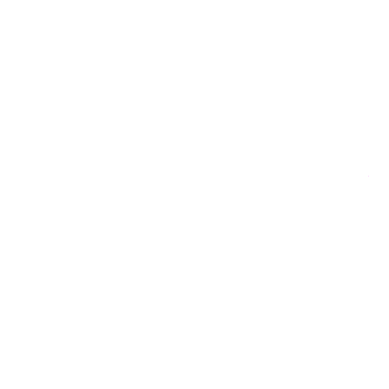

In [16]:
#Extract a small region from the large file (level 0)
#Let us extract a region from somewhere in the middle - coords 16k, 16k
#Extract 1024,1024 region
smaller_region = slide.read_region((40000,25000), 0, (1024,1024))
smaller_region_RGB = smaller_region.convert('RGB')
smaller_region_np = np.array(smaller_region_RGB, dtype=np.float64)
plt.axis('off')
plt.imshow(smaller_region_np)

norm_img, H_img, E_img = norm_HnE(smaller_region_np, Io=240, alpha=1, beta=0.15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


NameError: name 'norm_img' is not defined

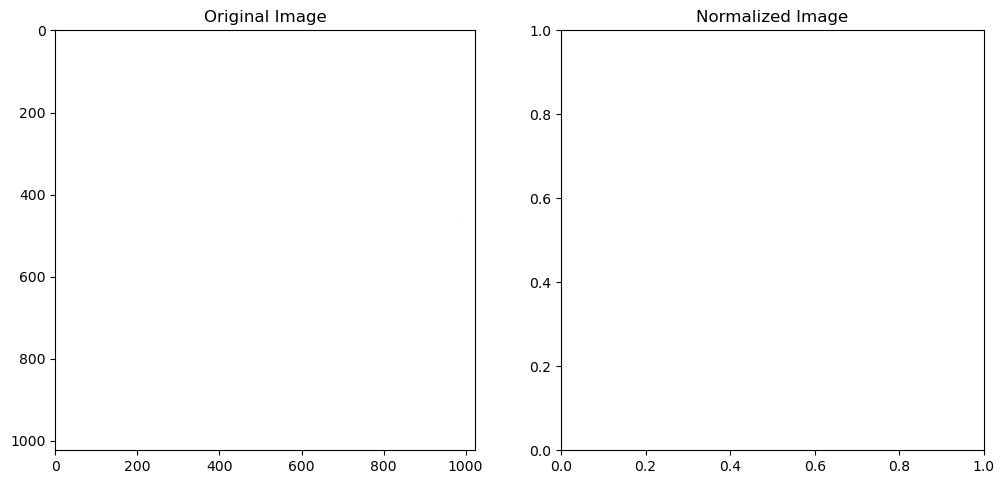

In [17]:
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Original Image')
plt.imshow(smaller_region_np)
plt.subplot(222)
plt.title('Normalized Image')
plt.imshow(norm_img)
plt.subplot(223)
plt.title('H image')
plt.imshow(H_img)
plt.subplot(224)
plt.title('E image')
plt.imshow(E_img)
plt.show()